## Setting Up Colab To Display RL Environment


*   Google Colab does not support rendering of Open AI Gym RL Environments
*   As a work around we will save agent interaction with the environment as video and display that video
*   Few cells given below are dedicated to this purpose only



In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

     |████████████████████████████████| 583kB 2.8MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 41.4.0
    Uninstalling setuptools-41.4.0:
      Successfully uninstalled setuptools-41.4.0


In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from base64 import b64encode

from IPython import display as ipythondisplay

In [3]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(700, 450))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '700x450x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '700x450x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 200px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

# Q Learning on Mountain Car Environment

In [5]:
!pip install gym #already installed

In [6]:
import gym
env = wrap_env(gym.make('MountainCar-v0')) #for discription https://github.com/openai/gym/wiki/MountainCar-v0
env.reset()

array([-0.50459273,  0.        ])

In [7]:
import random
done = False

while not done:
    action = (int(random.random()*10))%3 #action 0->push car left; action 1->do nothing; action 2-> push car right
    state, reward, done, _ = env.step(action)# state is a tuple of (position, velocity)
    print(state)

env.close()


[-5.04735202e-01 -1.42468084e-04]
[-0.50401907  0.00071613]
[-5.04449705e-01 -4.30632729e-04]
[-5.04023876e-01  4.25828220e-04]
[-0.50474478 -0.0007209 ]
[-0.506607   -0.00186223]
[-0.50959662 -0.00298961]
[-0.51169121 -0.0020946 ]
[-0.5148751  -0.00318388]
[-0.5181244  -0.00324931]
[-0.52241476 -0.00429036]
[-0.52571401 -0.00329924]
[-0.52799738 -0.00228338]
[-0.52924777 -0.00125039]
[-0.53145579 -0.00220802]
[-0.53460489 -0.0031491 ]
[-0.53867146 -0.00406657]
[-0.54362503 -0.00495356]
[-0.54742848 -0.00380346]
[-0.55205337 -0.00462489]
[-0.55546511 -0.00341174]
[-0.55963821 -0.0041731 ]
[-0.56354154 -0.00390333]
[-0.56814602 -0.00460448]
[-0.57141739 -0.00327137]
[-0.57533134 -0.00391396]
[-0.57785886 -0.00252752]
[-0.57998122 -0.00212236]
[-0.58168273 -0.00170151]
[-0.58395081 -0.00226808]
[-0.58676872 -0.00281791]
[-0.59011568 -0.00334696]
[-0.59296707 -0.00285139]
[-0.59430195 -0.00133488]
[-5.94110520e-01  1.91430044e-04]
[-0.59339419  0.00071633]
[-0.59215821  0.00123598]
[-0.59

In [0]:
show_video()#Displays the status of agent in last episode  
#the car needs to build momentum

In [8]:
#remove video to free memory
!rm video/*
env = wrap_env(gym.make('MountainCar-v0')) #for discription https://github.com/openai/gym/wiki/MountainCar-v0
env.reset()

array([-0.44802843,  0.        ])

## Implementing Q Table

We will be implementing SARSAMAX

![](SARSAMAX.png)

- State contains continous values
- Q Table will contains prohibitively large number of state values
- We need to **dicretize them** in order to create Q Table
- Initially Q Table will contain random values

In [9]:
#display observation space low and high values
print(env.observation_space.high)#[position,velocity]
print(env.observation_space.low)#[position, velocity]
print(env.action_space.n)

[0.6  0.07]
[-1.2  -0.07]
3


In [10]:
DISCRETE_OS_SIZE = [20] * len(env.observation_space.high)#os->observation space; 20 is the bucket size chosen by us (hyperparameter)
DISCRETE_OS_SIZE # We will have 20 discrete combinations for position and velocity. 
#State space will be 20 * 20 = 400

[20, 20]

In [11]:
#For each of 20 discrete state, we will have a bucket containing some range of position values and some range of velocity value
discrete_os_bucket_size = (env.observation_space.high-env.observation_space.low)/DISCRETE_OS_SIZE
discrete_os_bucket_size

array([0.09 , 0.007])

In [12]:
#creating Q Table
import numpy as np
#Q Table is assigned arbitrarily

#q_table = np.random.uniform(low=-2,high=0,size=(DISCRETE_OS_SIZE + [3])) #uniform is used when we want random values drawn from [low,high) range

q_table = np.zeros(DISCRETE_OS_SIZE + [3])

#low and high are randomly chosen
print(q_table.shape)
q_table #Q Table is of 3 Dimension  poition_bucket (20) * velocity_bucket (20) * action (3)

(20, 20, 3)


array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

## Now we will implement SARSAMAX algorithm to fill the Q Table

In [0]:
LEARNING_RATE = 0.1 #hyperparameter 
DISCOUNT = 0.95 #hyperparameter; how important are future rewards  
EPISODES = 20000 #hyperparameter
RENDER_EVERY = 5000

#a helper function to discretize continous states as returned by the environment 
def get_discrete_state(state):
    #discrete_state -> floor((current_state- lowest_state)/bucket_size)
    discrete_state = (state - env.observation_space.low) / discrete_os_bucket_size
    return tuple(discrete_state.astype(np.int)) #taking the floor value

In [0]:
# Exploration settings
epsilon = 1  # not a constant, qoing to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES//2
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)

In [15]:
for episode in range(EPISODES):
    done = False
    discrete_state = get_discrete_state(env.reset()) #we always start with initial discrete state
    if episode % RENDER_EVERY == 0:
        render=True
        print(episode)
    else:
        render=False
        
    while not done:
        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(q_table[discrete_state])
        else:
            # Get random action
            action = np.random.randint(0, env.action_space.n)
        state, reward, done, _ = env.step(action)# state is a tuple of (position, velocity)
        if render:
            #env.render() #Will not work in Google Colab
            pass
        new_discrete_state = get_discrete_state(state)
        if not done:
            q_st_at=q_table[discrete_state+(action,)]
            q_st_plus_1_a = np.max(q_table[new_discrete_state])
            new_q_st_at = q_st_at + LEARNING_RATE * (reward + DISCOUNT * q_st_plus_1_a - q_st_at)
            q_table[discrete_state+(action,)] = new_q_st_at
        elif state[0] >= env.goal_position: #if the episode terminates because we have achieved our goal
            new_q_st_at = q_st_at + LEARNING_RATE * (0 + DISCOUNT * q_st_plus_1_a - q_st_at)
        discrete_state = new_discrete_state
     # Decaying is being done every episode if episode number is within decaying range
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value
env.close()
show_video()#displays the agent interaction with evironment in last episode

0
5000
10000
15000


In [0]:
#remove video to free memory
!rm video/*

# QLearning on Cartpole Environment

In [17]:
!pip install gym #already installed

In [18]:
import gym
env = wrap_env(gym.make('CartPole-v0')) #for discription https://github.com/openai/gym/wiki/CartPole-v0
env.reset()

array([ 0.04625516,  0.02021164,  0.00533506, -0.00316445])

In [19]:
import random
done = False

while not done:
  action = (int(random.random()*10))%2 #action 0->push cart left; action 1->push cart right
  state, reward, done, _ = env.step(action)# state is a tuple of (cart position, cart velocity, pole angle, pole velocity at tip)
  print(state)  

env.close()
show_video()
#the cart need to balance the pole as much as possible

[ 0.0466594   0.21525667  0.00527178 -0.29415933]
[ 0.05096453  0.02005996 -0.00061141  0.00018156]
[ 0.05136573  0.21519067 -0.00060778 -0.29269421]
[ 0.05566954  0.41032128 -0.00646166 -0.58556876]
[ 0.06387597  0.60553314 -0.01817304 -0.88028015]
[ 0.07598663  0.80089721 -0.03577864 -1.17862044]
[ 0.09200457  0.99646505 -0.05935105 -1.48230114]
[ 0.11193388  1.19225863 -0.08899707 -1.79291335]
[ 0.13577905  0.9982397  -0.12485534 -1.52916736]
[ 0.15574384  0.80482519 -0.15543869 -1.27791616]
[ 0.17184035  0.61198824 -0.18099701 -1.03766326]
[ 0.18408011  0.41967262 -0.20175028 -0.80682517]
[ 0.19247356  0.61690334 -0.21788678 -1.15558373]


In [20]:
#remove video to free memory
!rm video/*
env = wrap_env(gym.make('CartPole-v0')) #for discription https://github.com/openai/gym/wiki/CartPole-v0
env.reset()

array([-0.04098085, -0.04358336,  0.03975057,  0.00405618])

## Implementing Q Table

We will be implementing SARSAMAX

![](SARSAMAX.png)

- State contains continous values
- Q Table will contains prohibitively large number of state values
- We need to **dicretize them** in order to create Q Table
- Initially Q Table will contain random values

In [21]:
#display observation space low and high values
print(env.observation_space.high)#[position,cart_velocity,pole_angle,pole_velocity]
print(env.observation_space.low)#[position,cart_velocity,pole_angle,pole_velocity]
print(env.action_space.n)

[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
2


In [0]:
#Reference 1 for discretizizng -> https://medium.com/@tuzzer/cart-pole-balancing-with-q-learning-b54c6068d947 
#Reference 2 for discretizing -> https://github.com/deepakkavoor/cartpole-rl/blob/master/cartpole-q_learning.py
import math
env.observation_space.high[1]= 0.5
env.observation_space.low[1]= -0.5
env.observation_space.high[3]= math.radians(50)
env.observation_space.low[3]= -math.radians(50)

In [23]:
import numpy as np
LEARNING_RATE = 0.1 #hyperparameter 
DISCOUNT = 0.95 #hyperparameter; how important are future rewards  
EPISODES = 20000 #hyperparameter
RENDER_EVERY = 1000


#Reference for discretizing=> https://mc.ai/openai-gyms-cart-pole-balancing-using-q-learning/
buckets=(1, 1, 6, 12,) #hyperparameter -> dimensions of Q Table (position,cart_velocity,pole_angle,pole_velocity)
q_table = np.zeros(buckets + (env.action_space.n,))
print(q_table.shape)


#a helper function to discretize continous states as returned by the environment 
def get_discrete_state(state):
    ratios = [(state[i] + abs(env.observation_space.low[i])) / (env.observation_space.high[i] - env.observation_space.low[i]) for i in range(len(state))]
    new_obs = [int(round((buckets[i] - 1) * ratios[i])) for i in range(len(state))]
    new_obs = [min(buckets[i] - 1, max(0, new_obs[i])) for i in range(len(state))]
    return tuple(new_obs)


(1, 1, 6, 12, 2)


In [0]:
# Exploration settings
epsilon = 1  # not a constant, qoing to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES//2
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)

In [25]:
for episode in range(EPISODES):
    done = False
    discrete_state = get_discrete_state(env.reset()) #we always start with initial discrete state'
    if episode % RENDER_EVERY == 0:
        render=True
        print(episode)
    else:
        render=False
    #steps_per_episode = 0
    while not done:
        
        if render:
            #env.render() # Will not work in Colab
            #steps_per_episode+=1
            #print('Step Count'+str(steps_per_episode))
            pass
        
        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(q_table[discrete_state])
        else:
            # Get random action
            action = np.random.randint(0, env.action_space.n)
        
        state, reward, done, _ = env.step(action)# state is a tuple of (position,cart_velocity,pole_angle,pole_velocity)
        new_discrete_state = get_discrete_state(state)
        if not done:
            q_st_at=q_table[discrete_state+(action,)]
            q_st_plus_1_a = np.max(q_table[new_discrete_state])
            new_q_st_at = q_st_at + LEARNING_RATE * (reward + DISCOUNT * q_st_plus_1_a - q_st_at)
            q_table[discrete_state+(action,)] = new_q_st_at
        discrete_state = new_discrete_state
     # Decaying is being done every episode if episode number is within decaying range
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value
env.close()
show_video()#displays the agent interaction with evironment in last episode

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


In [26]:
#remove video to free memory
!rm video/*
env = wrap_env(gym.make('CartPole-v0')) #for discription https://github.com/openai/gym/wiki/CartPole-v0
env.reset()

array([ 0.03316721,  0.00279346,  0.02626314, -0.03610807])

## Sample Run of Agent After Training

In [27]:
done = False
discrete_state = get_discrete_state(env.reset()) #we always start with initial discrete state'
steps=0
while not done:
    #steps+=1
    #print(steps)
    #env.render() # does not work in colab
        
    action = np.argmax(q_table[discrete_state])
        
    state, reward, done, _ = env.step(action)# state is a tuple of (position,cart_velocity,pole_angle,pole_velocity)

    discrete_state=get_discrete_state(state)
env.close()
show_video()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in float_scalars
  app.launch_new_instance()


In [28]:
#remove video to free memory
!rm video/*
env = wrap_env(gym.make('CartPole-v0')) #for discription https://github.com/openai/gym/wiki/CartPole-v0
env.reset()

array([ 0.00836097,  0.00353917,  0.00705049, -0.01645726])

# Q Learning Hyperparameter Optimization -> Finding Appropriate Number of Episodes

In [29]:
#display observation space low and high values
print(env.observation_space.high)#[position,cart_velocity,pole_angle,pole_velocity]
print(env.observation_space.low)#[position,cart_velocity,pole_angle,pole_velocity]
print(env.action_space.n)

[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
2


In [0]:
#Reference 1 for discretizizng -> https://medium.com/@tuzzer/cart-pole-balancing-with-q-learning-b54c6068d947 
#Reference 2 for discretizing -> https://github.com/deepakkavoor/cartpole-rl/blob/master/cartpole-q_learning.py
import math
env.observation_space.high[1]= 0.5
env.observation_space.low[1]= -0.5
env.observation_space.high[3]= math.radians(50)
env.observation_space.low[3]= -math.radians(50)

## Now we will implement SARSAMAX algorithm to fill the Q Table

In [31]:
import numpy as np
LEARNING_RATE = 0.05 #hyperparameter 
DISCOUNT = 0.95 #hyperparameter; how important are future rewards  
EPISODES = 25000 #hyperparameter
RENDER_EVERY = 1000
episode_rewards=[]#to store total reward obtained in each step
aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []}#To store various stats


#Reference for discretizing=> https://mc.ai/openai-gyms-cart-pole-balancing-using-q-learning/
buckets=(1, 1, 6, 12,) #hyperparameter -> dimensions of Q Table (position,cart_velocity,pole_angle,pole_velocity)
q_table = np.zeros(buckets + (env.action_space.n,))
print(q_table.shape)



#a helper function to discretize continous states as returned by the environment 
def get_discrete_state(state):
    ratios = [(state[i] + abs(env.observation_space.low[i])) / (env.observation_space.high[i] - env.observation_space.low[i]) for i in range(len(state))]
    new_obs = [int(round((buckets[i] - 1) * ratios[i])) for i in range(len(state))]
    new_obs = [min(buckets[i] - 1, max(0, new_obs[i])) for i in range(len(state))]
    return tuple(new_obs)

(1, 1, 6, 12, 2)


In [0]:
# Exploration settings
epsilon = 1  # not a constant, qoing to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES//2
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)

In [33]:
for episode in range(EPISODES):
    done = False
    discrete_state = get_discrete_state(env.reset()) #we always start with initial discrete state'
    if episode % RENDER_EVERY == 0:
        render=True
        print(episode)
    else:
        render=False
    steps_per_episode = 0
    episode_reward = 0#To track each episode rewards
    while not done:
        
        if render:
            #env.render() #->does not work in colab
            #steps_per_episode+=1
            #print('Step Count'+str(steps_per_episode))
            pass
        
        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(q_table[discrete_state])
        else:
            # Get random action
            action = np.random.randint(0, env.action_space.n)
        
        state, reward, done, _ = env.step(action)# state is a tuple of (position,cart_velocity,pole_angle,pole_velocity)
        episode_reward += reward
        new_discrete_state = get_discrete_state(state)
        if not done:
            q_st_at=q_table[discrete_state+(action,)]
            q_st_plus_1_a = np.max(q_table[new_discrete_state])
            new_q_st_at = q_st_at + LEARNING_RATE * (reward + DISCOUNT * q_st_plus_1_a - q_st_at)
            q_table[discrete_state+(action,)] = new_q_st_at
        discrete_state = new_discrete_state
    
    # Decaying is being done every episode if episode number is within decaying range
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value
    
    episode_rewards.append(episode_reward)
    if not episode % RENDER_EVERY:
        avg_reward = sum(episode_rewards[-RENDER_EVERY:])/RENDER_EVERY
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(avg_reward)
        aggr_ep_rewards['max'].append(max(episode_rewards[-RENDER_EVERY:]))
        aggr_ep_rewards['min'].append(min(episode_rewards[-RENDER_EVERY:]))
        
env.close()
show_video()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


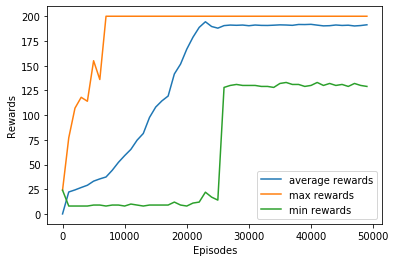

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt 
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label="average rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label="max rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label="min rewards")
plt.legend(loc=4)
plt.show()

In [35]:
print(aggr_ep_rewards['ep'])
print(aggr_ep_rewards['min'])
print(aggr_ep_rewards['avg'])

[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000, 46000, 47000, 48000, 49000]
[24.0, 8.0, 8.0, 8.0, 8.0, 9.0, 9.0, 8.0, 9.0, 9.0, 8.0, 10.0, 9.0, 8.0, 9.0, 9.0, 9.0, 9.0, 12.0, 9.0, 8.0, 11.0, 12.0, 22.0, 17.0, 14.0, 128.0, 130.0, 131.0, 130.0, 130.0, 130.0, 129.0, 129.0, 128.0, 132.0, 133.0, 131.0, 131.0, 129.0, 130.0, 133.0, 130.0, 132.0, 130.0, 131.0, 129.0, 132.0, 130.0, 129.0]
[0.024, 22.215, 24.305, 26.729, 29.023, 33.176, 35.454, 37.386, 44.17, 52.201, 59.014, 65.303, 74.616, 81.408, 97.609, 108.122, 114.403, 119.283, 141.588, 151.611, 166.708, 178.815, 188.727, 194.413, 189.621, 187.956, 190.52, 191.073, 190.841, 191.089, 190.414, 191.11, 190.75, 190.68, 190.952, 191.279, 191.122, 190.805, 191.672, 191.588, 191.818, 191.00

In [0]:
#remove video to free memory
!rm video/*

# Creating Own RL Environment

In [0]:
#May require to install opencv if it is not available: conda install -c menpo opencv

#REMEMBER: Open CV used BGR image encoding format
import cv2

import numpy as np 
from PIL import Image
import pickle #to save and load python objects
import matplotlib.pyplot as plt
from matplotlib import style 
import time
import os

In [0]:
#Setting the constants
SIZE = 10 #Grid size of environment will be 10*10
EPISODES = 24000
MOVE_PENALTY = 1
ENEMY_PENALTY = 300
FOOD_REWARD = 25
epsilon = 1 #epsilon greedy policy
EPS_DECAY = 0.9998
SHOW_EVERY = 3000
start_q_table = None #can be prior q table saved using pickle library
LEARNING_RATE = 0.1
DISCOUNT = 0.95

In [0]:
PLAYER_N=1
FOOD_N=2
ENEMY_N=3

#Our custom environment will display in BGR Format
d={1:(255,0,0), #Player is Blue
   2:(0,255,0), #Food is Green
   3:(0,0,255)  #Enemy is Red
}

In [0]:
#Creating class for player, food and enemy
class Blob:
    def __init__(self): #Python constructor
        self.x = np.random.randint(0,SIZE)
        self.y = np.random.randint(0,SIZE)
        #To Do: There can be a issue in which enemy and/or player and/or food land on the same cell
    
    #for debugging purposes
    def __str__(self):
        return f"{self.x}, {self.y}"
    
    #operator overloading
    def __sub__(self,second):
        return (self.x - second.x, self.y-second.y)
        
    #defining possible actions by Blob agent
    def action(self,choice): #very simplified discrete action space consisting of four actions only
        if choice == 0:
            self.move(x=1,y=1)
        elif choice==1:
            self.move(x=-1,y=-1)
        elif choice ==2:
            self.move(x=-1,y=1)
        elif choice ==3:
            self.move(x=1,y=-1)
        elif choice == 4:#Move right
            self.move(x=1,y=0)
        elif choice ==5 :#Move left
            self.move(x=-1,y=0)
        elif choice ==6: #Move Up
            self.move(x=0,y=1)
        elif choice ==7: #Move Down
            self.move(x=0,y=-1)
        #To Do: Add more choices
    
    def move(self, x=False,y=False):
        #The agent will move either randomly or based on value passed in x or y
        #if not x:#x is local var and self.x is class var
        #    self.x = np.random.randint(-1,2)  
        #else:
        self.x += x
            
        #if not y:
        #    self.y = np.random.randint(-1,2)  
        #else:
        self.y += y
        
        #We have to also ensure that blob does not move outside the boundaries
        if self.x < 0:
            self.x = 0
        elif self.x > (SIZE-1):
            self.x = SIZE-1
        
        if self.y < 0:
            self.y = 0
        elif self.y > (SIZE-1):
            self.y = SIZE-1

In [0]:
#States of our Q Table consist of difference between x and y coordinates of the player and food Blob AND player and enemy Blob
if start_q_table is None:
    q_table = {} #dictionary
    for x1 in range(-SIZE+1, SIZE):
        for y1 in range(-SIZE+1, SIZE):
            for x2 in range(-SIZE+1, SIZE):
                for y2 in range(-SIZE+1,SIZE):
                    q_table[((x1,y1),(x2,y2))]= [np.random.uniform(-5,0) for i in range(8)] #since there are eight discrete actions
                    #The initial values need to be modified to see the impact
                    
else: #The Q Table exists and may be present in the form of pickle object
    with open(start_q_table,"rb") as f:
        q_table = pickle.load(f)



## Q Learning Algorithm on Custom RL Environment

In [0]:
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
START_EPSILON_DECAYING = 1#From which episode we want to start to decay epsilon
END_EPSILON_DECAYING = EPISODES // 2 #Till which episode we want to decay epsilon
epsilon_decay_value = epsilon / (END_EPSILON_DECAYING - START_EPSILON_DECAYING)
episode_rewards = []
for episode in range(EPISODES):
    pathOut = f'{episode}.webm'#to hold files for rendering the environment
    player = Blob()
    food = Blob()
    enemy = Blob()
    
    if episode % SHOW_EVERY == 0:
        print(f'on #{episode}, epsilon: {epsilon}')
        print(f'ep mean {np.mean(episode_rewards[-SHOW_EVERY: ])}')
        show = True
    else:
        show = False
    
    #updating epsilon value
    
    episode_reward = 0
    img_frame = [] #to hold all different images of our environment
    for i in range(200): #Here 200 is the steps in each episode. It is a hyperparameter
        obs = (player - food, player - enemy)#Remember the function overriding
        if np.random.random() > epsilon:
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0,8)
        
        player.action(action)
       
        #Deciding the reward or penalty of agent after every step in each episode
        if player.x == enemy.x and player.y == enemy.y:
            reward = -ENEMY_PENALTY
        elif player.x == food.x and player.y == food.y:
            reward = FOOD_REWARD
        else:
            reward = -MOVE_PENALTY
            
        new_obs = (player-food,player-enemy)
        max_future_q = np.max(q_table[new_obs])
        current_q = q_table[obs][action]
    
        if reward == FOOD_REWARD:
            new_q = FOOD_REWARD
            q_table[obs][action] = new_q
            episode_rewards.append(reward)
            break
        elif reward == -ENEMY_PENALTY:
            new_q = -ENEMY_PENALTY
            q_table[obs][action] = new_q
            episode_rewards.append(reward)
            break
        else:
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            q_table[obs][action] = new_q
            episode_rewards.append(reward)
        
        #Code to display the environment
        if episode%SHOW_EVERY==0:
            env=np.zeros((SIZE,SIZE,3),dtype=np.uint8)
            env[food.y][food.x] = d[FOOD_N]
            env[player.y][player.x] = d[PLAYER_N]
            env[enemy.y][enemy.x] = d[ENEMY_N]            
            
            img = Image.fromarray(env,'RGB')#from PIL library
            img = img.resize((400,400))
            img_array=np.asarray(img)
            
            #replicate each frame 3 times so that rendering will display each frame longer
            img_frame.append(img_array)
            img_frame.append(img_array)
            img_frame.append(img_array)
            
    
    if episode%SHOW_EVERY==0:
        out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'VP80'), 25, (400,400))
        for i in range(len(img_frame)):
            # writing to a image array
            out.write(img_frame[i])
        out.release()

    # Decaying is being done every episode if episode number is within decaying range
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value

on #0, epsilon: 1
ep mean nan


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


on #3000, epsilon: 0.7500625052087145
ep mean -2.1786666666666665
on #6000, epsilon: 0.5000416701390725
ep mean -2.04
on #9000, epsilon: 0.2500208350694305
ep mean -1.4506666666666668
on #12000, epsilon: -1.451281315175551e-13
ep mean -0.5926666666666667
on #15000, epsilon: -8.334027850165784e-05
ep mean -0.545
on #18000, epsilon: -8.334027850165784e-05
ep mean -0.31966666666666665
on #21000, epsilon: -8.334027850165784e-05
ep mean -0.28933333333333333


### Visualization of Environment after 3000 Episodes

In [44]:
#Status of our environment after 3000 Episodes
#code to display ith episode
EPISODE = 3000 # can be 0, 3000, 6000, 9000, 12000, 15000, 18000,21000
webm = open(str(EPISODE)+'.webm','rb').read()
data_url = "data:video/webm;base64," + b64encode(webm).decode()
HTML("""
    <video width=400 height=400 autoplay loop controls>
    <source src="%s" type="video/webm">
    </video>
    """ % data_url)

### Visualization of Environment after 21000 Episodes

In [45]:
#Status of our environment after 3000 Episodes
#code to display ith episode
EPISODE = 21000 # can be 0, 3000, 6000, 9000, 12000, 15000, 18000,21000
webm = open(str(EPISODE)+'.webm','rb').read()
data_url = "data:video/webm;base64," + b64encode(webm).decode()
HTML("""
    <video width=400 height=400 autoplay loop controls>
    <source src="%s" type="video/webm">
    </video>
    """ % data_url)

# Deep Q Network (DQN)
![alt text](https://github.com/anubhavpatrick/Advanced-Deep-Learning-Workshop/raw/master/dqn.png)

In [46]:
import numpy as np
import keras.backend.tensorflow_backend as backend
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
import tensorflow as tf
from collections import deque
import time
import random
from tqdm import tqdm
import os
from PIL import Image
import cv2


DISCOUNT = 0.99
REPLAY_MEMORY_SIZE = 50_000  # How many last steps to keep for model training
MIN_REPLAY_MEMORY_SIZE = 1_000  # Minimum number of steps in a memory to start training
MINIBATCH_SIZE = 64  # How many steps (samples) to use for training
UPDATE_TARGET_EVERY = 5  # Terminal states (end of episodes)
MODEL_NAME = '2x256'
MIN_REWARD = -200  # For model save
MEMORY_FRACTION = 0.20

# Environment settings
EPISODES = 5_00

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.99975
MIN_EPSILON = 0.001

#  Stats settings
AGGREGATE_STATS_EVERY = 10  # episodes
SHOW_PREVIEW = True

Using TensorFlow backend.


In [0]:
#Custom RL Environment Coding
class Blob:
    def __init__(self, size):
        self.size = size
        self.x = np.random.randint(0, size)
        self.y = np.random.randint(0, size)

    def __str__(self):
        return f"Blob ({self.x}, {self.y})"

    def __sub__(self, other):
        return (self.x-other.x, self.y-other.y)

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y

    def action(self, choice):
        '''
        Gives us 9 total movement options. (0,1,2,3,4,5,6,7,8)
        '''
        if choice == 0:
            self.move(x=1, y=1)
        elif choice == 1:
            self.move(x=-1, y=-1)
        elif choice == 2:
            self.move(x=-1, y=1)
        elif choice == 3:
            self.move(x=1, y=-1)

        elif choice == 4:
            self.move(x=1, y=0)
        elif choice == 5:
            self.move(x=-1, y=0)

        elif choice == 6:
            self.move(x=0, y=1)
        elif choice == 7:
            self.move(x=0, y=-1)

        elif choice == 8:
            self.move(x=0, y=0)

    def move(self, x=False, y=False):

        # If no value for x, move randomly
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x

        # If no value for y, move randomly
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y

        # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > self.size-1:
            self.x = self.size-1
        if self.y < 0:
            self.y = 0
        elif self.y > self.size-1:
            self.y = self.size-1


class BlobEnv:
    SIZE = 10
    RETURN_IMAGES = True
    MOVE_PENALTY = 1
    ENEMY_PENALTY = 300
    FOOD_REWARD = 25
    OBSERVATION_SPACE_VALUES = (SIZE, SIZE, 3)  # 4
    ACTION_SPACE_SIZE = 9
    PLAYER_N = 1  # player key in dict
    FOOD_N = 2  # food key in dict
    ENEMY_N = 3  # enemy key in dict
    # the dict! (colors)
    d = {1: (0, 0, 255),
         2: (0, 255, 0),
         3: (255, 0, 0)}

    def reset(self):
        self.player = Blob(self.SIZE)
        self.food = Blob(self.SIZE)
        while self.food == self.player:
            self.food = Blob(self.SIZE)
        self.enemy = Blob(self.SIZE)
        while self.enemy == self.player or self.enemy == self.food:
            self.enemy = Blob(self.SIZE)

        self.episode_step = 0

        if self.RETURN_IMAGES:
            observation = np.array(self.get_image())
        else:
            observation = (self.player-self.food) + (self.player-self.enemy)
        return observation

    def step(self, action):
        self.episode_step += 1
        self.player.action(action)

        

        if self.RETURN_IMAGES:
            new_observation = np.array(self.get_image())
        else:
            new_observation = (self.player-self.food) + (self.player-self.enemy)

        if self.player == self.enemy:
            reward = -self.ENEMY_PENALTY
        elif self.player == self.food:
            reward = self.FOOD_REWARD
        else:
            reward = -self.MOVE_PENALTY

        done = False
        if reward == self.FOOD_REWARD or reward == -self.ENEMY_PENALTY or self.episode_step >= 200:
            done = True

        return new_observation, reward, done

    def render(self):
        img = self.get_image()
        img = img.resize((300, 300))  # resizing so we can see our agent in all its glory.
        #cv2.imshow("image", np.array(img))  # does not work in colab
        #cv2.waitKey(1)
        return img

    # FOR CNN #
    def get_image(self):
        env = np.zeros((self.SIZE, self.SIZE, 3), dtype=np.uint8)  # starts an rbg of our size
        env[self.food.x][self.food.y] = self.d[self.FOOD_N]  # sets the food location tile to green color
        env[self.enemy.x][self.enemy.y] = self.d[self.ENEMY_N]  # sets the enemy location to red
        env[self.player.x][self.player.y] = self.d[self.PLAYER_N]  # sets the player tile to blue
        img = Image.fromarray(env, 'RGB')  # reading to rgb. Apparently. Even tho color definitions are bgr. ???
        return img


env = BlobEnv()

In [69]:
#DQN Algorithnm
# For stats
ep_rewards = [-200]

# For more repetitive results
random.seed(1)
np.random.seed(1)
tf.set_random_seed(1)

# Memory fraction, used mostly when trai8ning multiple agents
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=MEMORY_FRACTION)
#backend.set_session(tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)))

# Create models folder
if not os.path.isdir('models'):
    os.makedirs('models')


# Own Tensorboard class
class ModifiedTensorBoard(TensorBoard):

    # Overriding init to set initial step and writer (we want one log file for all .fit() calls)
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.step = 1
        self.writer = tf.summary.FileWriter(self.log_dir)

    # Overriding this method to stop creating default log writer
    def set_model(self, model):
        pass

    # Overrided, saves logs with our step number
    # (otherwise every .fit() will start writing from 0th step)
    def on_epoch_end(self, epoch, logs=None):
        self.update_stats(**logs)

    # Overrided
    # We train for one batch only, no need to save anything at epoch end
    def on_batch_end(self, batch, logs=None):
        pass

    # Overrided, so won't close writer
    def on_train_end(self, _):
        pass

    # Custom method for saving own metrics
    # Creates writer, writes custom metrics and closes writer
    def update_stats(self, **stats):
        self._write_logs(stats, self.step)


# Agent class
class DQNAgent:
    def __init__(self):

        # Main model
        self.model = self.create_model()

        # Target network
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        # An array with last n steps for training
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

        # Custom tensorboard object
        self.tensorboard = ModifiedTensorBoard(log_dir="logs/{}-{}".format(MODEL_NAME, int(time.time())))

        # Used to count when to update target network with main network's weights
        self.target_update_counter = 0

    def create_model(self):
        model = Sequential()

        model.add(Conv2D(256, (3, 3), input_shape=env.OBSERVATION_SPACE_VALUES))  # OBSERVATION_SPACE_VALUES = (10, 10, 3) a 10x10 RGB image.
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Conv2D(256, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
        model.add(Dense(64))

        model.add(Dense(env.ACTION_SPACE_SIZE, activation='linear'))  # ACTION_SPACE_SIZE = how many choices (9)
        model.compile(loss="mse", optimizer=Adam(lr=0.001), metrics=['accuracy'])
        return model

    # Adds step's data to a memory replay array
    # (observation space, action, reward, new observation space, done)
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    # Trains main network every step during episode
    def train(self, terminal_state, step):

        # Start training only if certain number of samples is already saved
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return

        # Get a minibatch of random samples from memory replay table
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        # Get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0] for transition in minibatch])/255
        current_qs_list = self.model.predict(current_states)

        # Get future states from minibatch, then query NN model for Q values
        # When using target network, query it, otherwise main network should be queried
        new_current_states = np.array([transition[3] for transition in minibatch])/255
        future_qs_list = self.target_model.predict(new_current_states)

        X = []
        y = []

        # Now we need to enumerate our batches
        for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):

            # If not a terminal state, get new q from future states, otherwise set it to 0
            # almost like with Q Learning, but we use just part of equation here
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward

            # Update Q value for given state
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # And append to our training data
            X.append(current_state)
            y.append(current_qs)

        # Fit on all samples as one batch, log only on terminal state
        self.model.fit(np.array(X)/255, np.array(y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False, callbacks=[self.tensorboard] if terminal_state else None)

        # Update target network counter every episode
        if terminal_state:
            self.target_update_counter += 1

        # If counter reaches set value, update target network with weights of main network
        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0

    # Queries main network for Q values given current observation space (environment state)
    def get_qs(self, state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape)/255)[0]


agent = DQNAgent()

# Iterate over episodes
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):

    pathOut = f'{episode}dqn.webm'#to hold files for rendering the environment
    img_frame = [] #to hold all different images of our environment
    # Update tensorboard step every episode
    agent.tensorboard.step = episode

    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1

    # Reset environment and get initial state
    current_state = env.reset()

    # Reset flag and start iterating until episode ends
    done = False
    while not done:

        # This part stays mostly the same, the change is to query a model for Q values
        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(agent.get_qs(current_state))
        else:
            # Get random action
            action = np.random.randint(0, env.ACTION_SPACE_SIZE)

        new_state, reward, done = env.step(action)

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward

        if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
            #env.render() #does not work in colab
            img_array=np.asarray(env.render())
            
            #replicate each frame 3 times so that rendering will display each frame longer
            img_frame.append(img_array)
            img_frame.append(img_array)
            img_frame.append(img_array)


        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done, step)

        current_state = new_state
        step += 1

    # Append episode reward to a list and log stats (every given number of episodes)
    ep_rewards.append(episode_reward)
    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        agent.tensorboard.update_stats(reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon)

        # Save model, but only when min reward is greater or equal a set value
        if min_reward >= MIN_REWARD:
            agent.model.save(f'models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.model')

    #Writing the visualization as video file
    if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
        out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'VP80'), 25, (300,300))
        for i in range(len(img_frame)):
            # writing to a image array
            out.write(img_frame[i])
        out.release()

    # Decay epsilon
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)



  0%|          | 0/5000 [00:00<?, ?episodes/s]

  0%|          | 1/5000 [00:00<12:38,  6.59episodes/s]

  0%|          | 7/5000 [00:00<09:21,  8.89episodes/s]

  0%|          | 10/5000 [00:00<10:31,  7.90episodes/s]

  0%|          | 12/5000 [00:03<40:23,  2.06episodes/s]

  0%|          | 13/5000 [00:04<1:04:46,  1.28episodes/s]

  0%|          | 14/5000 [00:05<57:18,  1.45episodes/s]  

  0%|          | 15/5000 [00:05<44:24,  1.87episodes/s]

  0%|          | 16/5000 [00:07<1:26:05,  1.04s/episodes]

  0%|          | 17/5000 [00:12<2:51:04,  2.06s/episodes]

  0%|          | 18/5000 [00:14<2:59:17,  2.16s/episodes]

  0%|          | 19/5000 [00:15<2:37:20,  1.90s/episodes]

  0%|          | 20/5000 [00:15<1:52:56,  1.36s/episodes]

  0%|          | 21/5000 [00:17<2:09:32,  1.56s/episodes]

  0%|          | 22/5000 [00:19<1:57:39,  1.42s/episodes]

  0%|          | 23/5000 [00:20<1:59:57,  1.45s/episodes]

  0%|          | 24/5000 [00:20<1:33:42,  1.13s/episodes]

  0%|          | 2

KeyboardInterrupt: ignored

### Visualization of Environment after 10 Episodes




In [70]:
#Status of our environment after 10 Episodes
#code to display ith episode
EPISODE = 10 # can be 0, 20, 30, 40 ........5000 
webm = open(str(EPISODE)+'dqn.webm','rb').read()
data_url = "data:video/webm;base64," + b64encode(webm).decode()
HTML("""
    <video width=300 height=300 autoplay loop controls>
    <source src="%s" type="video/webm">
    </video>
    """ % data_url)

### Visualization of Environment after 100 Episodes


In [67]:
#Status of our environment after 10 Episodes
#code to display ith episode
EPISODE = 100 # can be 0, 20, 30, 40 ........5000 
webm = open(str(EPISODE)+'dqn.webm','rb').read()
data_url = "data:video/webm;base64," + b64encode(webm).decode()
HTML("""
    <video width=300 height=300 autoplay loop controls>
    <source src="%s" type="video/webm">
    </video>
    """ % data_url)

In [0]:
!rm *webm